In [2]:
# Import các thư viện cần thiết
import torch
import learn2learn as l2l
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, TensorDataset

In [3]:
# Load dữ liệu
data = pd.read_csv("./ADBE_Stock.csv")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [4]:
data

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Date,Symbol,Adj Close,Close,High,Low,Open,Volume
0,3/1/2019,ADBE,264.010010,264.010010,266.239990,261.500000,265.750000,2594000
1,3/4/2019,ADBE,258.160004,258.160004,267.000000,254.080002,266.700012,2994900
2,3/5/2019,ADBE,257.380005,257.380005,259.869995,256.369995,259.000000,2101800
3,3/6/2019,ADBE,256.399994,256.399994,259.489990,253.839996,257.399994,1950500
4,3/7/2019,ADBE,255.460007,255.460007,257.489990,253.289993,255.770004,3185200
...,...,...,...,...,...,...,...,...
1319,5/28/2024,ADBE,478.429993,478.429993,478.670013,469.600006,473.010010,2575300
1320,5/29/2024,ADBE,477.600006,477.600006,482.790008,472.600006,472.779999,2214800
1321,5/30/2024,ADBE,445.869995,445.869995,466.820007,444.839996,464.899994,5606900
1322,5/31/2024,ADBE,444.760010,444.760010,448.230011,433.970001,447.720001,7487500


In [5]:
data.describe()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Adj Close,Close,High,Low,Open,Volume
count,1324.000000,1324.000000,1324.000000,1324.000000,1324.000000,1.324000e+03
mean,437.561171,437.561171,442.956797,431.746496,437.548852,2.987458e+06
std,112.802864,112.802864,113.786692,111.798628,112.881015,1.733830e+06
min,254.740005,254.740005,255.020004,249.100006,251.490005,5.892000e+05
25%,339.532501,339.532501,344.690010,333.492500,338.960007,2.039850e+06
50%,443.785004,443.785004,449.224991,436.915009,444.769989,2.573100e+06
75%,514.142502,514.142502,520.422485,508.869987,514.000000,3.413750e+06
max,688.369995,688.369995,699.539978,678.909973,696.280029,2.784020e+07


In [6]:
# Check Null
data.info()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1324 entries, 0 to 1323
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       1324 non-null   object 
 1   Symbol     1324 non-null   object 
 2   Adj Close  1324 non-null   float64
 3   Close      1324 non-null   float64
 4   High       1324 non-null   float64
 5   Low        1324 non-null   float64
 6   Open       1324 non-null   float64
 7   Volume     1324 non-null   int64  
dtypes: float64(5), int64(1), object(2)
memory usage: 82.9+ KB


In [7]:
def detect_outlier(df, col):
    q1 = np.percentile(df[col], 25)
    q3 = np.percentile(df[col], 75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    print(df[(df[col] < lower_bound) | (df[col] > upper_bound)])

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [8]:
detect_outlier(data, 'Close')

Empty DataFrame
Columns: [Date, Symbol, Adj Close, Close, High, Low, Open, Volume]
Index: []


Không có outliers

In [9]:
df=data.reset_index()['Close']

In [10]:
df

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


0       264.010010
1       258.160004
2       257.380005
3       256.399994
4       255.460007
           ...    
1319    478.429993
1320    477.600006
1321    445.869995
1322    444.760010
1323    439.019989
Name: Close, Length: 1324, dtype: float64

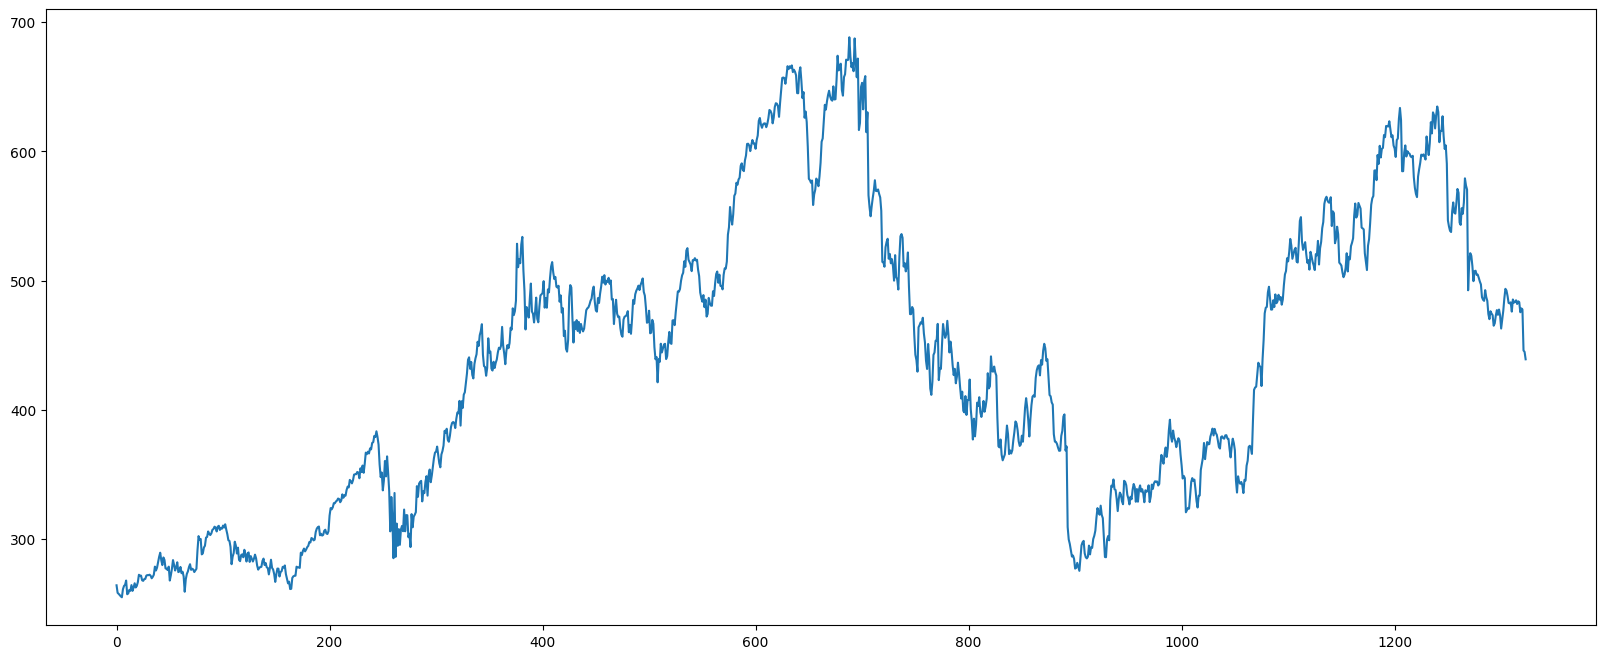

In [11]:
plt.figure(figsize=(20, 8))
plt.plot(df)
plt.show()

In [12]:
# Chuẩn hóa dữ liệu sử dụng MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
df = scaler.fit_transform(np.array(df).reshape(-1,1))

In [13]:
df

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


array([[0.02137768],
       [0.0078869 ],
       [0.00608814],
       ...,
       [0.44076746],
       [0.43820771],
       [0.42497057]])

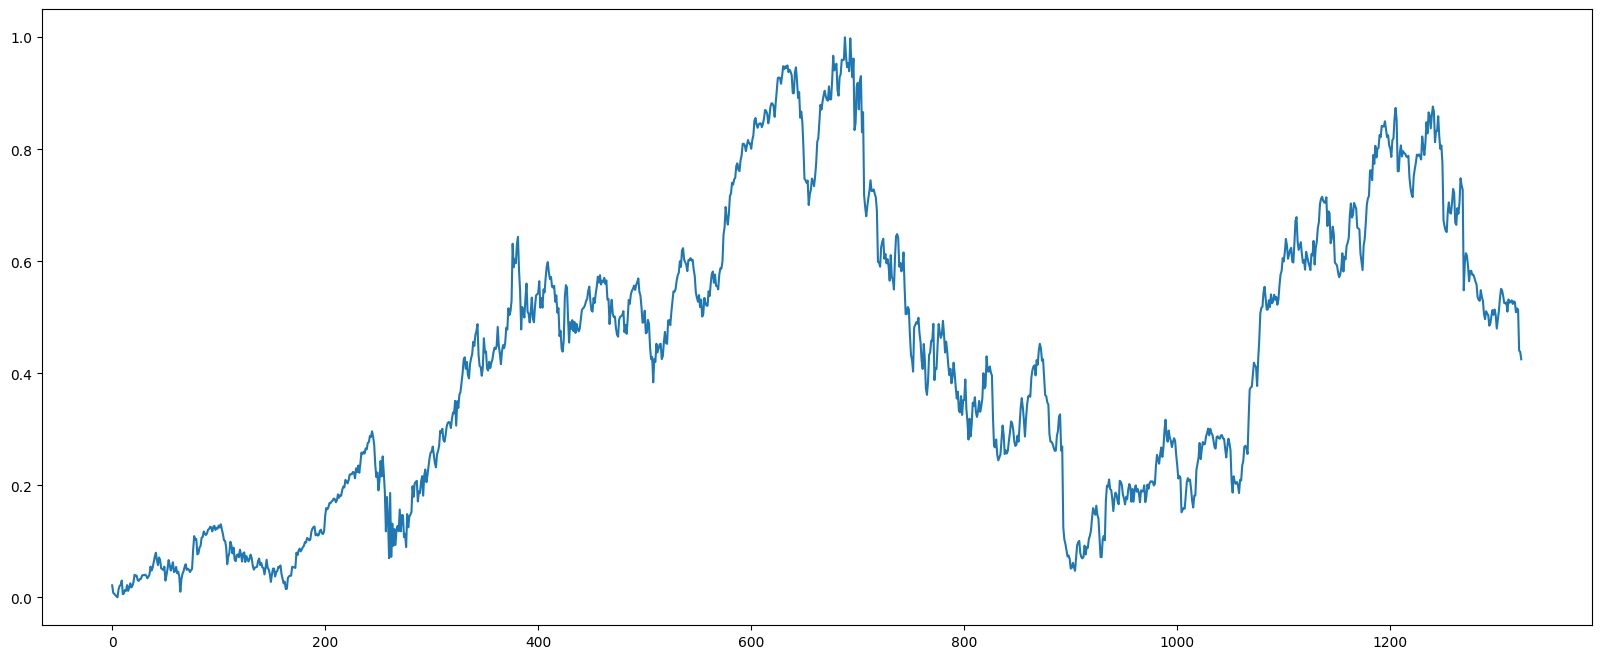

In [14]:
plt.figure(figsize=(20, 8))
plt.plot(df)
plt.show()

In [15]:
# Chia train test
train_size = int(0.7 * len(df))
test_size = len(df) - train_size

train_data = df[:train_size]
test_data = df[train_size:]

In [16]:
# Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [17]:
# Reshape into X=t,t+1,t+2..t+99 and Y=t+100

time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [18]:
# Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [19]:
# Tạo DataLoader
train_dataset = TensorDataset(torch.Tensor(X_train), torch.Tensor(y_train))
test_dataset = TensorDataset(torch.Tensor(X_test), torch.Tensor(ytest))
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [20]:
# Xây dựng mô hình
class StockPredictor(nn.Module):
    def __init__(self):
        super(StockPredictor, self).__init__()
        self.lstm = nn.LSTM(input_size=1, hidden_size=50, num_layers=2, batch_first=True, dropout=0.2)
        self.fc = nn.Linear(50, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])
        return out

In [21]:
# Định nghĩa hàm meta-learning
def fast_adapt(batch, learner, loss, adaptation_steps, device):
    data, labels = batch
    data, labels = data.to(device), labels.to(device)
    for step in range(adaptation_steps):
        predictions = learner(data).view(-1)
        train_loss = loss(predictions, labels.view(-1))
        learner.adapt(train_loss)
    return train_loss

In [22]:
# Định nghĩa quá trình training
def meta_train(maml, train_loader, meta_optimizer, loss, adaptation_steps, meta_batch_size, device):
    for epoch in range(100):
        meta_loss = 0.0
        for batch in train_loader:
            learner = maml.clone()
            batch_loss = fast_adapt(batch, learner, loss, adaptation_steps, device)
            meta_loss += batch_loss.item()
            meta_optimizer.zero_grad()
            batch_loss.backward()
            # Ensure that only leaf tensors are used to calculate the gradients
            for param in maml.parameters():
                if param.grad is not None:
                    param.grad = param.grad.clone().detach()
            meta_optimizer.step()
        print(f'Epoch {epoch+1}, Loss: {meta_loss/len(train_loader)}')

In [23]:
# Khởi tạo mô hình và các thành phần cần thiết
device = torch.device('cpu')
model = StockPredictor().to(device)
maml = l2l.algorithms.MAML(model, lr=0.01)
meta_optimizer = optim.Adam(maml.parameters(), lr=0.001)
loss = nn.MSELoss()

In [24]:
# Training mô hình
meta_train(maml, train_loader, meta_optimizer, loss, adaptation_steps=3, meta_batch_size=32, device=device)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:810: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at aten/src/ATen/core/TensorBody.h:489.)
  param_grad = param.grad


Epoch 1, Loss: 0.2783226428123621
Epoch 2, Loss: 0.11361709065162219
Epoch 3, Loss: 0.06777517669475995
Epoch 4, Loss: 0.055184848606586456
Epoch 5, Loss: 0.0474766601736729
Epoch 6, Loss: 0.03691399742204409
Epoch 7, Loss: 0.018372873345819805
Epoch 8, Loss: 0.007780277886642859
Epoch 9, Loss: 0.0066188185189205865
Epoch 10, Loss: 0.006010221460690865
Epoch 11, Loss: 0.005367592263680238
Epoch 12, Loss: 0.0052775452808978465
Epoch 13, Loss: 0.004932873792803058
Epoch 14, Loss: 0.004687214270234108
Epoch 15, Loss: 0.004647780962001819
Epoch 16, Loss: 0.004279636831667561
Epoch 17, Loss: 0.003986031121502702
Epoch 18, Loss: 0.0040800437295379546
Epoch 19, Loss: 0.0038789075154524585
Epoch 20, Loss: 0.0036693811058424986
Epoch 21, Loss: 0.0034681785350235608
Epoch 22, Loss: 0.003417918566041268
Epoch 23, Loss: 0.0034818986538224495
Epoch 24, Loss: 0.0032495767093048645
Epoch 25, Loss: 0.003091502612313399
Epoch 26, Loss: 0.0031259517686871383
Epoch 27, Loss: 0.0030415541349122156
Epoch 2

In [25]:
# Dự đoán và hiển thị kết quả trên tập test
model.eval()
predictions = []
with torch.no_grad():
    for i in range(len(X_test)):
        x = torch.Tensor(X_test[i:i+1]).to(device)
        pred = model(x).cpu().numpy()
        predictions.append(pred)

predictions = np.array(predictions).flatten()
predictions = scaler.inverse_transform(predictions.reshape(-1, 1)).flatten()

In [26]:
ytest = scaler.inverse_transform(ytest.reshape(-1,1))
# Tính MAPE
def calculate_mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

#  Tính MAE
def calculate_mae(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    mae = np.mean(np.abs(y_true - y_pred))
    return mae

# Tính toán RMSE, MAPE và MDA
test_rmse = np.sqrt(np.mean((predictions - ytest) ** 2))
test_mape = calculate_mape(ytest, predictions)
test_mae = calculate_mae(ytest, predictions)

# In kết quả
print('Testing RMSE:', test_rmse)
print('Testing MAPE:', test_mape)
print('Testing MAE:', test_mae)

Testing RMSE: 108.90766782804143
Testing MAPE: 17.75721899957212
Testing MAE: 86.09054213286066


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [27]:
# Dự báo 30 ngày tiếp theo
x_input = test_data[-time_step:].reshape(1, -1)
temp_input = list(x_input)
temp_input = temp_input[0].tolist()

lst_output_30 = []
n_steps = x_input.shape[1]
i = 0

model.eval()
while (i < 30):
    if (len(temp_input) > n_steps):
        x_input = np.array(temp_input[1:])
        x_input = x_input.reshape((1, n_steps, 1))
        x_tensor = torch.Tensor(x_input).to(device)
        with torch.no_grad():
            yhat = model(x_tensor).cpu().numpy()
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]
        lst_output_30.extend(yhat.tolist())
        i = i + 1
    else:
        x_input = x_input.reshape((1, n_steps, 1))
        x_tensor = torch.Tensor(x_input).to(device)
        with torch.no_grad():
            yhat = model(x_tensor).cpu().numpy()
        temp_input.extend(yhat[0].tolist())
        lst_output_30.extend(yhat.tolist())
        i = i + 1

# Chuyển đổi kết quả dự đoán trở lại dạng giá trị ban đầu
predicted_30_days = scaler.inverse_transform(np.array(lst_output_30).reshape(-1, 1))

# Hiển thị kết quả
print("Dự báo 30 ngày tiếp theo:")
print(predicted_30_days)


Dự báo 30 ngày tiếp theo:
[[451.22731514]
 [444.33135082]
 [438.60276326]
 [433.77282784]
 [429.65178058]
 [426.07353275]
 [422.89156134]
 [419.98232074]
 [417.24705199]
 [414.6112142 ]
 [412.02183525]
 [409.4438933 ]
 [406.85624605]
 [404.24799925]
 [401.61523718]
 [398.95852845]
 [396.28098755]
 [393.58706006]
 [390.88146294]
 [388.16886146]
 [385.4533781 ]
 [382.73874768]
 [380.02812344]
 [377.3242451 ]
 [374.62955515]
 [371.94610836]
 [369.27606291]
 [366.62120219]
 [363.98346469]
 [361.36473719]]


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [28]:
# Dự báo 60 ngày tiếp theo
x_input = test_data[-time_step:].reshape(1, -1)
temp_input = list(x_input)
temp_input = temp_input[0].tolist()

lst_output_60 = []
n_steps = x_input.shape[1]
i = 0

model.eval()
while (i < 60):
    if (len(temp_input) > n_steps):
        x_input = np.array(temp_input[1:])
        x_input = x_input.reshape((1, n_steps, 1))
        x_tensor = torch.Tensor(x_input).to(device)
        with torch.no_grad():
            yhat = model(x_tensor).cpu().numpy()
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]
        lst_output_60.extend(yhat.tolist())
        i = i + 1
    else:
        x_input = x_input.reshape((1, n_steps, 1))
        x_tensor = torch.Tensor(x_input).to(device)
        with torch.no_grad():
            yhat = model(x_tensor).cpu().numpy()
        temp_input.extend(yhat[0].tolist())
        lst_output_60.extend(yhat.tolist())
        i = i + 1

# Chuyển đổi kết quả dự đoán trở lại dạng giá trị ban đầu
predicted_60_days = scaler.inverse_transform(np.array(lst_output_60).reshape(-1, 1))

# Hiển thị kết quả
print("Dự báo 60 ngày tiếp theo:")
print(predicted_60_days)


Dự báo 60 ngày tiếp theo:
[[451.22731514]
 [444.33135082]
 [438.60276326]
 [433.77282784]
 [429.65178058]
 [426.07353275]
 [422.89156134]
 [419.98232074]
 [417.24705199]
 [414.6112142 ]
 [412.02183525]
 [409.4438933 ]
 [406.85624605]
 [404.24799925]
 [401.61523718]
 [398.95852845]
 [396.28098755]
 [393.58706006]
 [390.88146294]
 [388.16886146]
 [385.4533781 ]
 [382.73874768]
 [380.02812344]
 [377.3242451 ]
 [374.62955515]
 [371.94610836]
 [369.27606291]
 [366.62120219]
 [363.98346469]
 [361.36473719]
 [358.76685478]
 [356.19174302]
 [353.64132745]
 [351.11749487]
 [348.62222251]
 [346.15742302]
 [343.72495732]
 [341.32671221]
 [338.96447108]
 [336.63999148]
 [334.35488881]
 [332.11081725]
 [329.90919833]
 [327.75145361]
 [325.63882371]
 [323.57249757]
 [321.5534832 ]
 [319.58269813]
 [317.66094362]
 [315.78885289]
 [313.96695579]
 [312.19565294]
 [310.47518989]
 [308.80571848]
 [307.18724517]
 [305.6196698 ]
 [304.10277269]
 [302.63620491]
 [301.21954645]
 [299.85226101]]


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [29]:
# Dự báo 90 ngày tiếp theo
x_input = test_data[-time_step:].reshape(1, -1)
temp_input = list(x_input[0])


lst_output_90 = []
n_steps = x_input.shape[1]
i = 0

model.eval()
while (i < 90):
    if (len(temp_input) > n_steps):
        x_input = np.array(temp_input[1:])
        x_input = x_input.reshape((1, n_steps, 1))
        x_tensor = torch.Tensor(x_input).to(device)
        with torch.no_grad():
            yhat = model(x_tensor).cpu().numpy()
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]
        lst_output_90.extend(yhat.tolist())
        i = i + 1
    else:
        x_input = x_input.reshape((1, n_steps, 1))
        x_tensor = torch.Tensor(x_input).to(device)
        with torch.no_grad():
            yhat = model(x_tensor).cpu().numpy()
        temp_input.extend(yhat[0].tolist())
        lst_output_90.extend(yhat.tolist())
        i = i + 1

# Chuyển đổi kết quả dự đoán trở lại dạng giá trị ban đầu
predicted_90_days = scaler.inverse_transform(np.array(lst_output_90).reshape(-1, 1))

# Hiển thị kết quả
print("Dự báo 90 ngày tiếp theo:")
print(predicted_90_days)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Dự báo 90 ngày tiếp theo:
[[451.22731514]
 [444.33135082]
 [438.60276326]
 [433.77282784]
 [429.65178058]
 [426.07353275]
 [422.89156134]
 [419.98232074]
 [417.24705199]
 [414.6112142 ]
 [412.02183525]
 [409.4438933 ]
 [406.85624605]
 [404.24799925]
 [401.61523718]
 [398.95852845]
 [396.28098755]
 [393.58706006]
 [390.88146294]
 [388.16886146]
 [385.4533781 ]
 [382.73874768]
 [380.02812344]
 [377.3242451 ]
 [374.62955515]
 [371.94610836]
 [369.27606291]
 [366.62120219]
 [363.98346469]
 [361.36473719]
 [358.76685478]
 [356.19174302]
 [353.64132745]
 [351.11749487]
 [348.62222251]
 [346.15742302]
 [343.72495732]
 [341.32671221]
 [338.96447108]
 [336.63999148]
 [334.35488881]
 [332.11081725]
 [329.90919833]
 [327.75145361]
 [325.63882371]
 [323.57249757]
 [321.5534832 ]
 [319.58269813]
 [317.66094362]
 [315.78885289]
 [313.96695579]
 [312.19565294]
 [310.47518989]
 [308.80571848]
 [307.18724517]
 [305.6196698 ]
 [304.10277269]
 [302.63620491]
 [301.21954645]
 [299.85226101]
 [298.53373472

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


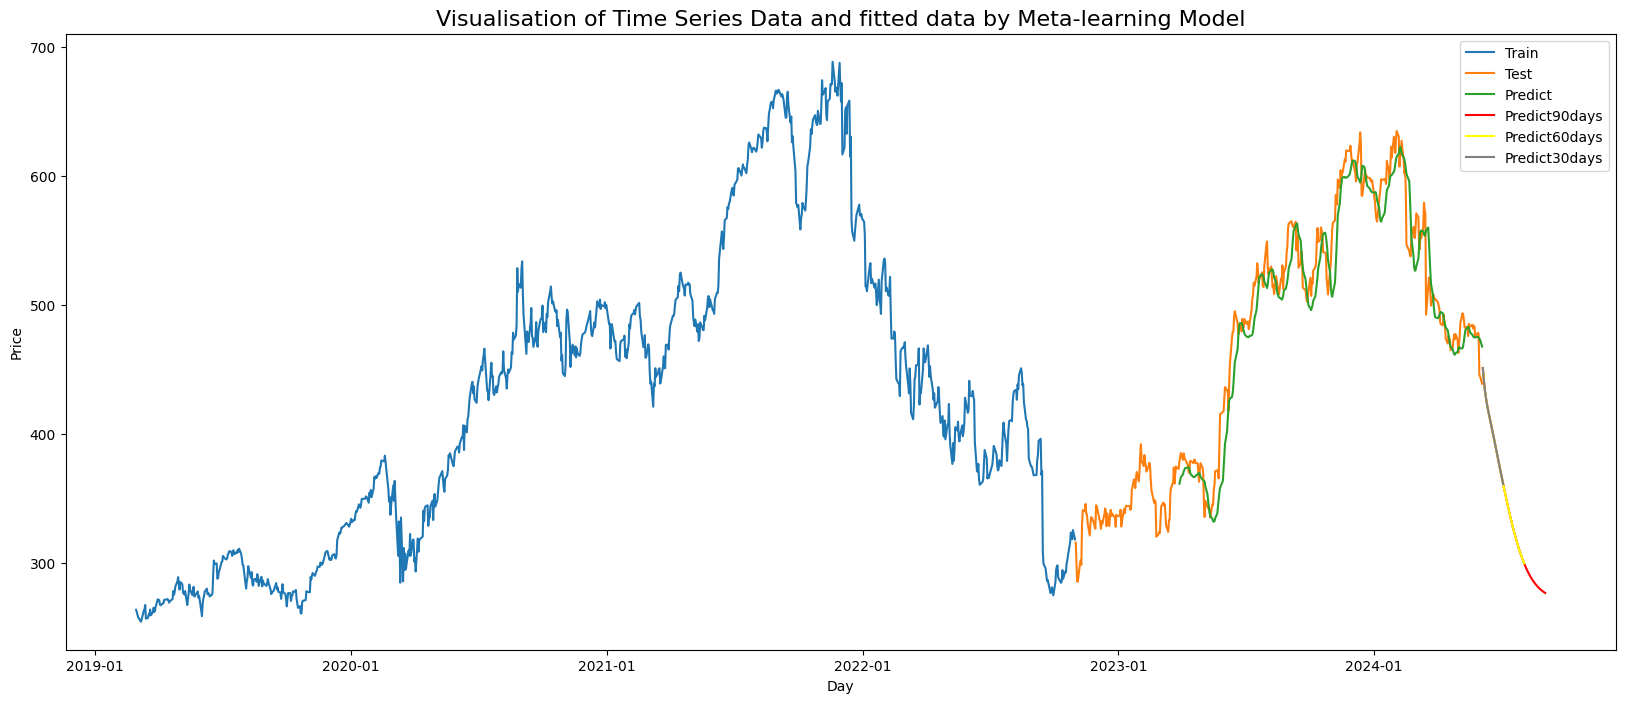

In [30]:
# 14.Vẽ hình
import matplotlib.dates as mdates
plt.figure(figsize=(20, 8))

data['Date'] = pd.to_datetime(data['Date'])
plt.plot(data['Date'][:train_size],scaler.inverse_transform(train_data))
plt.plot(data['Date'][train_size:],scaler.inverse_transform(test_data))
plt.plot(data['Date'][train_size+101:],(predictions))

predict_data_index_90 = pd.bdate_range(start=data['Date'][len(data['Date'])-1] + pd.Timedelta(days=1), periods=90, freq='D')
predict_data_index_60 = pd.bdate_range(start=data['Date'][len(data['Date'])-1] + pd.Timedelta(days=1), periods=60, freq='D')
predict_data_index_30 = pd.bdate_range(start=data['Date'][len(data['Date'])-1] + pd.Timedelta(days=1), periods=30, freq='D')

plt.plot(predict_data_index_90,scaler.inverse_transform(lst_output_90), color='red')
plt.plot(predict_data_index_60,scaler.inverse_transform(lst_output_60), color='yellow')
plt.plot(predict_data_index_30,scaler.inverse_transform(lst_output_30), color='grey')
plt.legend(['Train','Test','Predict','Predict90days', 'Predict60days', 'Predict30days'])
plt.title('Visualisation of Time Series Data and fitted data by Meta-learning Model' , fontsize=16)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
plt.xlabel('Day')
plt.ylabel('Price')
plt.show()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


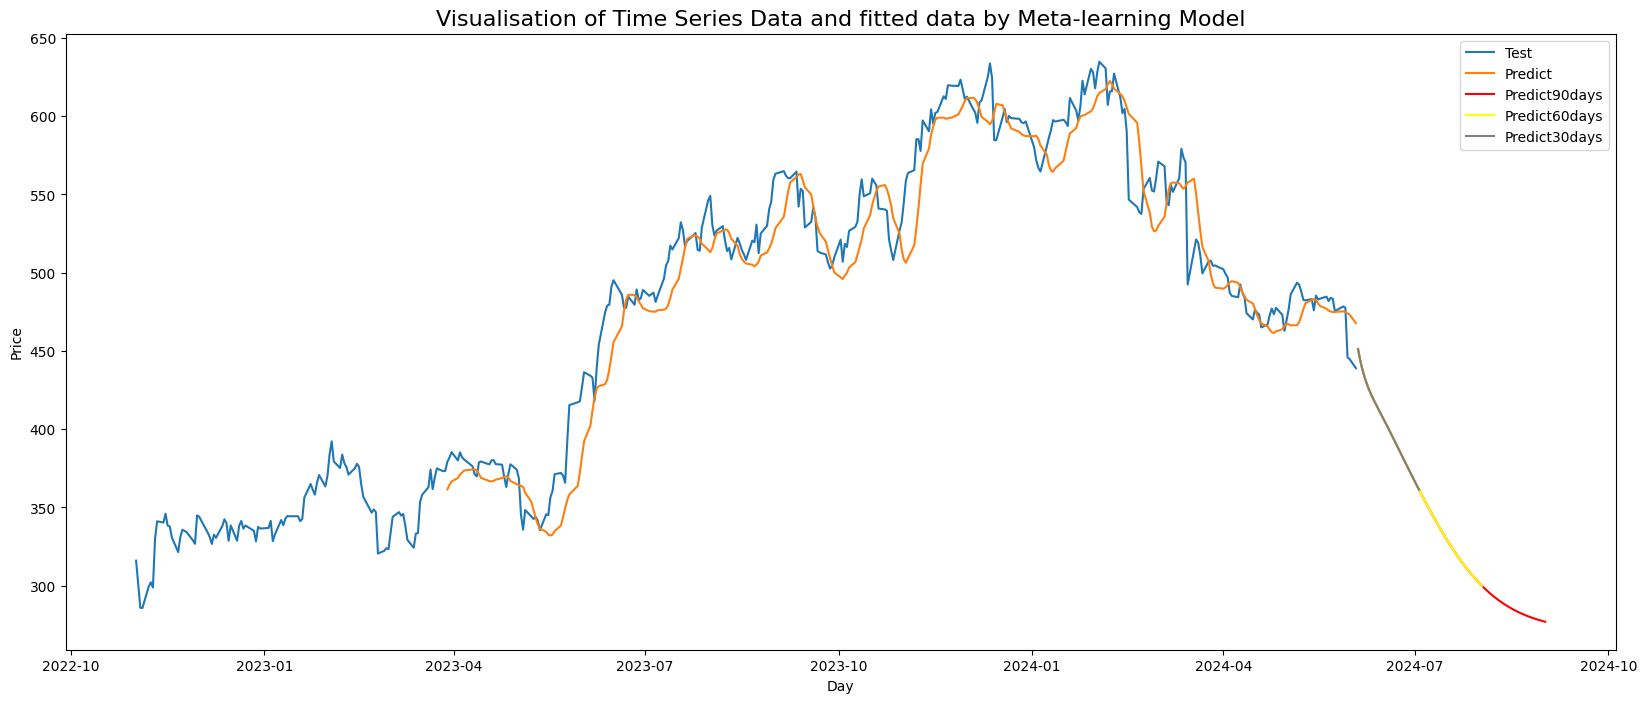

In [31]:
# 15.Vẽ hình test prediction
import matplotlib.dates as mdates
plt.figure(figsize=(20, 8))

data['Date'] = pd.to_datetime(data['Date'])
plt.plot(data['Date'][train_size:],scaler.inverse_transform(test_data))
plt.plot(data['Date'][train_size+101:],(predictions))

predict_data_index_90 = pd.bdate_range(start=data['Date'][len(data['Date'])-1] + pd.Timedelta(days=1), periods=90, freq='D')
predict_data_index_60 = pd.bdate_range(start=data['Date'][len(data['Date'])-1] + pd.Timedelta(days=1), periods=60, freq='D')
predict_data_index_30 = pd.bdate_range(start=data['Date'][len(data['Date'])-1] + pd.Timedelta(days=1), periods=30, freq='D')

plt.plot(predict_data_index_90,scaler.inverse_transform(lst_output_90), color='red')
plt.plot(predict_data_index_60,scaler.inverse_transform(lst_output_60), color='yellow')
plt.plot(predict_data_index_30,scaler.inverse_transform(lst_output_30), color='grey')
plt.legend(['Test','Predict','Predict90days', 'Predict60days', 'Predict30days'])
plt.title('Visualisation of Time Series Data and fitted data by Meta-learning Model' , fontsize=16)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
plt.xlabel('Day')
plt.ylabel('Price')
plt.show()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


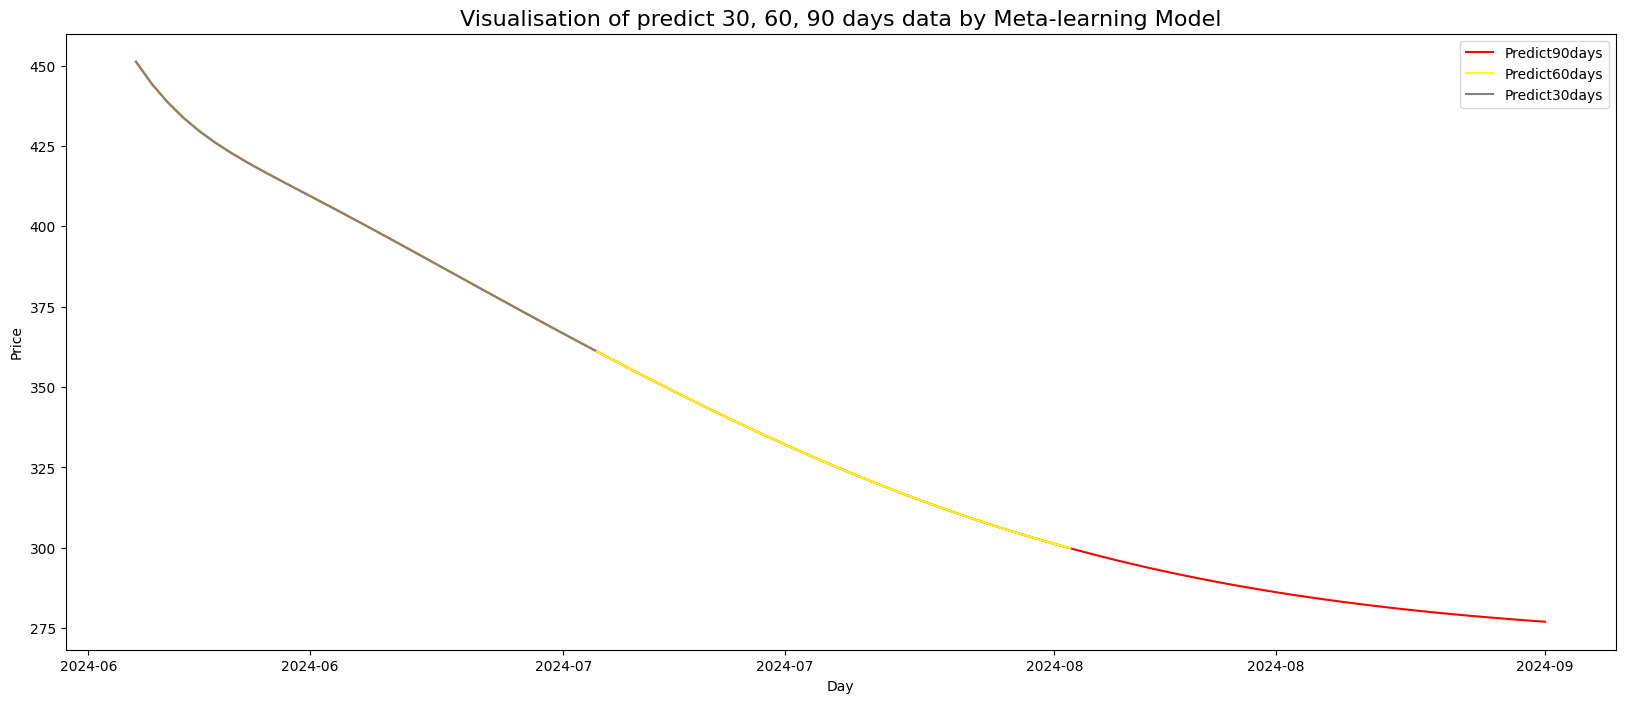

In [32]:
plt.figure(figsize=(20, 8))
plt.plot(predict_data_index_90,scaler.inverse_transform(lst_output_90), color='red')
plt.plot(predict_data_index_60,scaler.inverse_transform(lst_output_60), color='yellow')
plt.plot(predict_data_index_30,scaler.inverse_transform(lst_output_30), color='grey')
plt.legend(['Predict90days', 'Predict60days', 'Predict30days'])
plt.title('Visualisation of predict 30, 60, 90 days data by Meta-learning Model' , fontsize=16)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
plt.xlabel('Day')
plt.ylabel('Price')
plt.show()